<a href="https://colab.research.google.com/github/RobyRoshna/Insensitive-Lang-Detection/blob/Augmentation/Augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**1. Imports** <a name="imports"></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from huggingface_hub import login
import wandb
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, set_seed
import pandas as pd
import random
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import pickle
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
#Note: random_state for splits need to set separately for this study its 42 throughout
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
set_seed(42)

### Custom dataset and metrics class




In [ ]:
# Custom Dataset Class for Tokenized Data
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and the corresponding label for the given index.

        Args:
            idx: Index of the data sample.

        Returns:
            A dictionary containing the tokenized inputs (input IDs, attention masks, etc.)
            and the label for the specified index.
        """
        # Convert tokenized data for the index to PyTorch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Ensure the label key is 'labels'
        item['labels'] = torch.tensor(self.labels[idx])  # Add the corresponding label
        return item

# Function to compute metrics
def compute_metrics(pred):
    predictions, labels = pred
    preds = predictions.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Pure GPT on unaug


Loaded Model Path: /content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model



Test Set Evaluation
Accuracy: 0.7156
Precision: 0.7125
Recall: 0.6953
F1 Score: 0.6984

Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        52                     11
Actual Insensitive                           20                     26

False Positives:
                                              Sentence  Manual_Annotation
0    Physical therapists have a history of modifyin...                  0
17   However, such systems are awkward and slow to ...                  0
31   However, language immersion can be particularl...                  0
54   People with Autism Spectrum Disorder (ASD) are...                  0
57   These abilities, as many other individual attr...                  0
63   All dyslexic subjects tested were able to use ...                  0
77   We observed 11 low vision participants using t...                  0
83   Without a commonly accepted writing system for...     

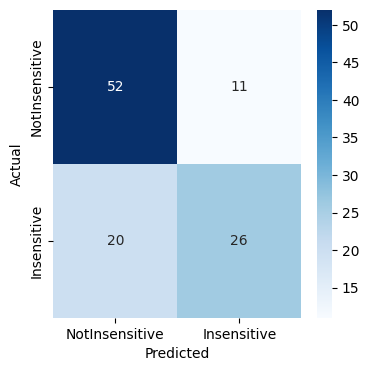

test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.7156
test_f1,0.69844
test_precision,0.71246
test_recall,0.69531


In [ ]:
import pandas as pd
import torch
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_dataexp = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv")

# Load the saved model
model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model"
modelAug = BertForSequenceClassification.from_pretrained(model_path)
modelAug.eval()

print("\nLoaded Model Path:", model_path)

wandb.finish()
wandb.init(project="Insensitive Lang Detection", entity="Roshna", name="Bert_baseOripredGPT")

tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_dataexp['Sentence']), padding=True, truncation=True, return_tensors="pt")


with torch.no_grad():
    outputs = modelAug(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)

test_predictions = outputs.logits.argmax(dim=1).cpu().numpy()
test_true_labels = test_dataexp['Manual_Annotation'].values


accuracy = accuracy_score(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions, output_dict=True)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Extract Precision, Recall, and F1-score - macro average gives equal importance to both classes in binary classification
precision = class_report["macro avg"]["precision"]
recall = class_report["macro avg"]["recall"]
f1 = class_report["macro avg"]["f1-score"]

wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})


print("\nTest Set Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                              index=["Actual NotInsensitive", "Actual Insensitive"])

print("\nConfusion Matrix - Test Set:")
print(conf_matrix_df)

wandb.log({"confusion_matrix": wandb.Table(dataframe=conf_matrix_df)})

# Analyze false positives & false negatives
false_positives = test_dataexp[(test_true_labels == 0) & (test_predictions == 1)].copy()
false_negatives = test_dataexp[(test_true_labels == 1) & (test_predictions == 0)].copy()

print("\nFalse Positives:")
print(false_positives[['Sentence', 'Manual_Annotation']])

print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Manual_Annotation']])

# Confidence scores
test_dataexp['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_dataexp['Confidence_Negative'] = confidences[:, 0].cpu().numpy()

# Assign confidence values to misclassified examples
false_positives['Confidence_Positive'] = test_dataexp.loc[false_positives.index, 'Confidence_Positive'].values
false_negatives['Confidence_Negative'] = test_dataexp.loc[false_negatives.index, 'Confidence_Negative'].values

print("\nFalse Positives with Confidence:")
print(false_positives[['Sentence', 'Manual_Annotation', 'Confidence_Positive']])

print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Manual_Annotation', 'Confidence_Negative']])

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NotInsensitive", "Insensitive"],
            yticklabels=["NotInsensitive", "Insensitive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("OriginalTestset.png")
plt.show()

# Finish WandB logging
wandb.finish()


## **2. Pure generated Data** <a name="gendata"></a>

In [ ]:

# The augmentated dataset
file_path = '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_generated.xlsx'
data = pd.read_excel(file_path)

# cleaning data
data = data[['Sentence', 'Label','Term']]
data = data.dropna()

# 1 for insensitive and 0 for notInsensitive
data['Label'] = data['Label'].apply(lambda x: 1 if x.lower() == 'insensitive' else 0)

#train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['Label'],random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['Label'],random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")
# Save splits
train_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtrain_data.csv", index=False)
val_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTval_data.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtest_data.csv", index=False)

Train size: 1720, Validation size: 215, Test size: 215


In [ ]:
train_data=pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtrain_data.csv")
val_data=pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTval_data.csv")
test_data=pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtest_data.csv")
print(f"Duplicates in train data: {train_data.duplicated(subset=['Sentence', 'Label']).sum()}")
print(f"Duplicates in validation data: {val_data.duplicated(subset=['Sentence', 'Label']).sum()}")
print(f"Duplicates in test data: {test_data.duplicated(subset=['Sentence', 'Label']).sum()}")


Duplicates in train data: 0
Duplicates in validation data: 0
Duplicates in test data: 0


### Tokenizer

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize data
def tokenize_data(data, tokenizer, max_length=109):
    return tokenizer(
        list(data['Sentence']),
        padding=True,
        truncation=True,         # Truncate longer sentences
        max_length=max_length,   # Max token length
        return_tensors='pt'      # Return PyTorch tensors
    )

train_labelsChatGPT = list(train_data['Label'])
val_labelsChatGPT = list(val_data['Label'])
test_labelsChatGPT = list(test_data['Label'])

# Tokenize the data
train_encodingsChatGPT = tokenize_data(train_data, tokenizer)
val_encodingsChatGPT = tokenize_data(val_data, tokenizer)
test_encodingsChatGPT = tokenize_data(test_data, tokenizer)


# Save tokenized data
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtrain_encodings_input_ids.npy", train_encodingsChatGPT['input_ids'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtrain_encodings_attention_mask.npy", train_encodingsChatGPT['attention_mask'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtrain_labels.npy", np.array(train_labelsChatGPT))


In [ ]:

# Create datasets for train, validation, and test sets
train_datasetChatGPT = SentenceDataset(train_encodingsChatGPT, train_labelsChatGPT)
val_datasetChatGPT = SentenceDataset(val_encodingsChatGPT, val_labelsChatGPT)
test_datasetChatGPT = SentenceDataset(test_encodingsChatGPT, test_labelsChatGPT)


# Save the train, val, and test datasets
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtrain_dataset.pkl", "wb") as f:
    pickle.dump(train_datasetChatGPT, f)
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTval_dataset.pkl", "wb") as f:
    pickle.dump(val_datasetChatGPT, f)
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTtest_dataset.pkl", "wb") as f:
    pickle.dump(test_datasetChatGPT, f)


In [ ]:
#Examples from the training dataset
for i in range(5):
    item = train_datasetChatGPT[i]
    print("Input IDs:", item['input_ids'])
    print("Attention Mask:", item['attention_mask'])
    print("Label:", item['labels'])  # 0 for Not Insensitive, 1 for Insensitive


Input IDs: tensor([  101,  1000,  2256,  2470, 11637,  1996,  7860,  4320,  2011,  3633,
         2007,  2012, 22571,  7476,  2591, 15592,  1012,  1000,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor(1)
Input IDs: tensor([  101,  1000,  3671, 12969,  3798,  2024,  3223,  2000,  3929, 16462,
         1996,  2838,  1997,  1996,  5080,  1012,  1000,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor(1)
Input IDs: tensor([ 101, 1000, 1996, 5009, 2001, 2522, 1011, 2764, 2007, 8519, 2013, 1996,
        2569, 3791, 2470, 2523, 1012, 1000,  102,    0,    0,

<ipython-input-5-c840719b0958>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


### Model Training

In [ ]:
# Load pre-trained BERT for binary classification
modelBbaseChatGPT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(modelBbaseChatGPT.config)


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:

wandb.finish()

# Initialize WandB
wandb.init(project="Insensitive Lang Detecton", entity="Roshna", name="Bert_baseChatGPT")

# TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    report_to=["wandb"],  # WandB is used for logging
    run_name="Bert_baseChatGPT"  # the run name for this Trainer
)

# Trainer
trainer = Trainer(
    model=modelBbaseChatGPT,
    args=training_args,
    train_dataset=train_datasetChatGPT,
    eval_dataset=val_datasetChatGPT,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

results = trainer.evaluate(test_datasetChatGPT, metric_key_prefix="test")
wandb.log(results)

wandb.finish()  # Close the evaluation session


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-c840719b0958>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.212700,0.064114,0.967442,0.980952,0.953704,0.967136
2,0.050800,0.074954,0.981395,0.972727,0.990741,0.981651
3,0.007500,0.106145,0.976744,0.963964,0.990741,0.977169


<ipython-input-5-c840719b0958>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-5-c840719b0958>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-5-c840719b0958>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-5-c840719b0958>:29: UserWarning: To copy construct from a 

epoch,▁
eval/accuracy,▁█▆
eval/f1,▁█▆
eval/loss,▁▃█
eval/precision,█▅▁
eval/recall,▁██
eval/runtime,▁▁█
eval/samples_per_second,██▁
eval/steps_per_second,██▁
test/accuracy,▁
test/f1,▁


In [ ]:
# Save the trained model and tokenizer
save_directory = "/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model"
trainer.save_model(save_directory)  # Save model
tokenizer.save_pretrained(save_directory)  # Save tokenizer

('/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model/tokenizer_config.json',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model/special_tokens_map.json',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model/vocab.txt',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model/added_tokens.json')

### Model Results

In [ ]:
wandb.init(project="Insensitive Lang Detecton", entity="Roshna", name="Bert_baseGPT")

# Extract predictions and true labels
test_predictions = test_results.predictions.argmax(axis=1)  # Get predicted classes
test_true_labels = test_results.label_ids

# Evaluate the predictions using classification_report
print("Classification Report on Test Data:")
from sklearn.metrics import classification_report
print(classification_report(test_true_labels, test_predictions, target_names=["notInsensitive", "Insensitive"]))

# Save predictions along with the test data
test_data['Predicted_Label'] = test_predictions
test_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_basetest_predictions.csv", index=False)
print("Predictions saved to '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_basetest_predictions.csv'")

# Get predictions on the training data using the same method
train_results = trainer.predict(train_datasetChatGPT)

# Extract training predictions and labels
train_predictions = train_results.predictions.argmax(axis=1)
train_true_labels = train_results.label_ids

# Evaluate the predictions on the training data
print("Classification Report on Training Data:")
print(classification_report(train_true_labels, train_predictions, target_names=["notInsensitive", "Insensitive"]))

# Save training predictions
train_data['Predicted_Label'] = train_predictions
train_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_basetrain_predictions.csv", index=False)
print("Training predictions saved to '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_basetrain_predictions.csv'")



Training Metrics:
     Metric  Value
0  Accuracy    1.0

Classification Report:
                 precision    recall  f1-score   support

NotInsensitive       1.00      1.00      1.00       860
   Insensitive       1.00      1.00      1.00       860

      accuracy                           1.00      1720
     macro avg       1.00      1.00      1.00      1720
  weighted avg       1.00      1.00      1.00      1720


Validation Metrics:
      Metric    Value
0   accuracy  0.97674
1         f1  0.97717
2  precision  0.96396
3     recall  0.99074

Test Metrics:
     Metric     Value
0  Accuracy  0.986047

Classification Report:
                 precision    recall  f1-score   support

NotInsensitive       1.00      0.97      0.99       108
   Insensitive       0.97      1.00      0.99       107

      accuracy                           0.99       215
     macro avg       0.99      0.99      0.99       215
  weighted avg       0.99      0.99      0.99       215



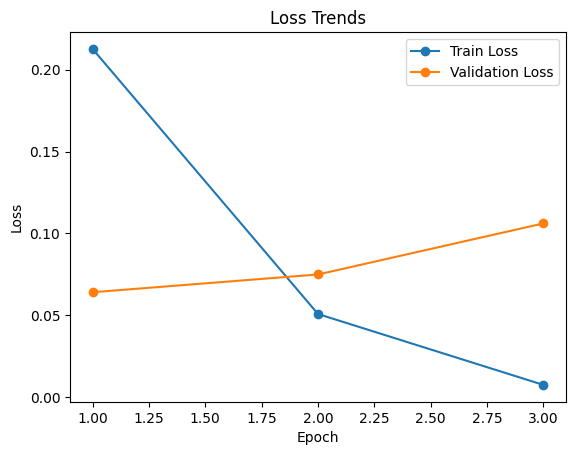

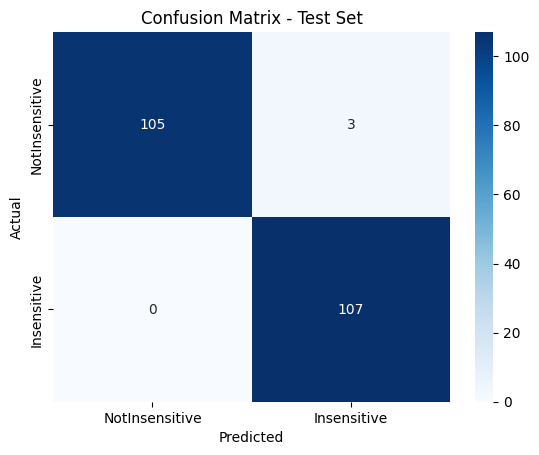

False Positives:
                                              Sentence      Term
55   "Our system reduces the cognitive load for use...   spastic
63   "Our research explores the challenges faced by...  disorder
173  "The program was developed to recognize atypic...  atypical

False Negatives:
Empty DataFrame
Columns: [Sentence, Term]
Index: []
False Positives with Confidence:
                                              Sentence      Term  \
55   "Our system reduces the cognitive load for use...   spastic   
63   "Our research explores the challenges faced by...  disorder   
173  "The program was developed to recognize atypic...  atypical   

     Confidence_Positive  
55              0.961620  
63              0.998154  
173             0.999288  

False Negatives with Confidence:
Empty DataFrame
Columns: [Sentence, Term, Confidence_Negative]
Index: []


<ipython-input-22-89202a1ac51c>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['Confidence_Positive'] = test_data.loc[false_positives.index, 'Confidence_Positive']


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load test predictions and true labels
test_data = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_basetest_predictions.csv")
true_labels = test_data['Label']
predicted_labels = test_data['Predicted_Label']
ChatGPT_train_data = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_basetrain_predictions.csv")
ChatGPT_train_true_labels = ChatGPT_train_data['Label']
ChatGPT_train_predicted_labels = ChatGPT_train_data['Predicted_Label']

# **1. Compare Train, Validation, and Test Metrics**
train_metrics = {
    "accuracy": accuracy_score(ChatGPT_train_true_labels, ChatGPT_train_predicted_labels),
    "classification_report": classification_report(
        ChatGPT_train_true_labels, ChatGPT_train_predicted_labels, target_names=["NotInsensitive", "Insensitive"]
    )}

val_metrics = {"accuracy": 0.97674, "f1": 0.97717, "precision": 0.96396, "recall": 0.99074}
test_metrics = {
    "accuracy": accuracy_score(true_labels, predicted_labels),
    "classification_report": classification_report(true_labels, predicted_labels, target_names=["NotInsensitive", "Insensitive"]),
}


# Training Metrics
train_df = pd.DataFrame({
    "Metric": ["Accuracy"],
    "Value": [train_metrics["accuracy"]],
})
print("\nTraining Metrics:")
print(train_df)
print("\nClassification Report:\n", train_metrics["classification_report"])

# Validation Metrics
val_df = pd.DataFrame(val_metrics.items(), columns=["Metric", "Value"])
print("\nValidation Metrics:")
print(val_df)

# Test Metrics
test_df = pd.DataFrame({
    "Metric": ["Accuracy"],
    "Value": [test_metrics["accuracy"]],
})
print("\nTest Metrics:")
print(test_df)
print("\nClassification Report:\n", test_metrics["classification_report"])


epochs = [1, 2, 3]
train_losses = [0.212700, 0.050800, 0.007500]  # Training losses for epochs 1, 2, and 3 check training results above
val_losses = [0.064114, 0.074954, 0.106145]

plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trends")
plt.legend()
plt.savefig("PureGenloss_trends.png")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["NotInsensitive", "Insensitive"], yticklabels=["NotInsensitive", "Insensitive"])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("PureGenconfusion_matrix.png")
plt.show()

# Analyze false positives and false negatives
false_positives = test_data[(true_labels == 0) & (predicted_labels == 1)]
false_negatives = test_data[(true_labels == 1) & (predicted_labels == 0)]

print("False Positives:")
print(false_positives[['Sentence', 'Term']])

print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Term']])


model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPTbert_base_model"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()


from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_data['Sentence']), padding=True, truncation=True, return_tensors="pt")

# model outputs
with torch.no_grad():
    outputs = model(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)  # Get probabilities


test_data['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_data['Confidence_Negative'] = confidences[:, 0].cpu().numpy()

false_positives['Confidence_Positive'] = test_data.loc[false_positives.index, 'Confidence_Positive']
false_negatives['Confidence_Negative'] = test_data.loc[false_negatives.index, 'Confidence_Negative']

print("False Positives with Confidence:")
print(false_positives[['Sentence', 'Term', 'Confidence_Positive']])

print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Term', 'Confidence_Negative']])


## **3. Augmented Data Original + GPT** <a name="augdata"></a>

### Augmentation Process - removing test set before augmentation

In [ ]:
import pandas as pd

# File paths
file1 = "/content/drive/MyDrive/Honours MiscData(Roshna)/deduplicated_annotations.xlsx"
file2 = "/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.xlsx"
output_file1 = "/content/drive/MyDrive/Honours MiscData(Roshna)/AbstractswithoutTestset.xlsx"

df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)

# Ensure the 'Sentence' column exists in both files
if 'Sentence' not in df1.columns or 'Sentence' not in df2.columns:
    raise ValueError("One of the files does not contain a 'Sentence' column.")

# Convert 'Sentence' columns to strings for consistency
df1['Sentence'] = df1['Sentence'].astype(str)
df2['Sentence'] = df2['Sentence'].astype(str)

# Identify sentences in File1 that are also in File2
common_sentences = df1['Sentence'][df1['Sentence'].isin(df2['Sentence'])]

# Remove sentences in File1 that are also in File2
df1_no_common = df1[~df1['Sentence'].isin(df2['Sentence'])]

# Count the number of sentences removed
removed_count = len(common_sentences)

# Save the modified dataframe to a new file
df1_no_common.to_excel(output_file1, index=False)

# Print confirmation and count of removed sentences
print(f"New file with sentences removed from File1 saved to: {output_file1}")
print(f"Number of sentences removed from File1: {removed_count}")

# Optional: Print the first few rows of the modified file
print("\nFirst 5 rows of File1 without common sentences:")
print(df1_no_common.head())


New file with sentences removed from File1 saved to: /content/drive/MyDrive/Honours MiscData(Roshna)/AbstractswithoutTestset.xlsx
Number of sentences removed from File1: 109

First 5 rows of File1 without common sentences:
                                               Title  \
1  Sketching images eyes-free: a grid-based dynam...   
2  Sketching images eyes-free: a grid-based dynam...   
3  Sketching images eyes-free: a grid-based dynam...   
5  Design and implementation of virtual environme...   
6  Multimodal virtual reality versus printed medi...   

                                            Sentence      Matched_Terms  \
1  The experiment included eight visually impaire...  visually impaired   
2  The results show that auditory interpretation ...  visually impaired   
3  Further, the experiment demonstrates that visu...  visually impaired   
5  Twenty-six blind persons conducted the tests a...       blind person   
6  In this paper, we describe a study comparing t...  visually im

### V3 augmented

In [ ]:
import pandas as pd


original_file_path = '/content/drive/MyDrive/Honours MiscData(Roshna)/AbstractswithoutTestset.xlsx'
generated_file_path = '/content/drive/MyDrive/Honours MiscData(Roshna)/ChatGPT_generated.xlsx'

original_data = pd.read_excel(original_file_path)
generated_data = pd.read_excel(generated_file_path)

original_data = original_data.rename(columns={"Matched_Terms": "Term", "Manual_Annotation": "Label"})
generated_data = generated_data.rename(columns={"Sentence": "Sentence", "Term": "Term", "Label": "Label"})

original_data['Label'] = original_data['Label'].apply(lambda x: 1 if x.lower() == "insensitive" else 0)
generated_data['Label'] = generated_data['Label'].apply(lambda x: 1 if x.lower() == "insensitive" else 0)

original_data['Source'] = 'Original'
generated_data['Source'] = 'ChatGPT'

# Ensure generated data has all required columns
if 'Prompt' not in generated_data.columns:
    generated_data['Prompt'] = None

# Initialize augmented dataset
augmented_data = []

# Get unique terms from the lexicon
terms = list(set(original_data['Term'].dropna().unique()) | set(generated_data['Term'].dropna().unique()))

# Define the required number of sentences per term and label
required_count = 25

# Augment data for each term
for term in terms:
    term_data = []

    # Filter original and generated datasets for this term
    original_term_data = original_data[original_data['Term'] == term]
    generated_term_data = generated_data[generated_data['Term'] == term]

    # Select insensitive sentences
    insensitive_original = original_term_data[original_term_data['Label'] == 1].sample(
        n=min(required_count, len(original_term_data[original_term_data['Label'] == 1])),
        random_state=42
    )
    insensitive_generated = generated_term_data[generated_term_data['Label'] == 1].sample(
        n=max(0, required_count - len(insensitive_original)),
        random_state=42
    )

    # Select notInsensitive sentences
    not_insensitive_original = original_term_data[original_term_data['Label'] == 0].sample(
        n=min(required_count, len(original_term_data[original_term_data['Label'] == 0])),
        random_state=42
    )
    not_insensitive_generated = generated_term_data[generated_term_data['Label'] == 0].sample(
        n=max(0, required_count - len(not_insensitive_original)),
        random_state=42
    )

    # Combine selected data
    term_data.extend(insensitive_original.to_dict(orient='records'))
    term_data.extend(insensitive_generated.to_dict(orient='records'))
    term_data.extend(not_insensitive_original.to_dict(orient='records'))
    term_data.extend(not_insensitive_generated.to_dict(orient='records'))
    augmented_data.extend(term_data)

augmented_df = pd.DataFrame(augmented_data)

#only the required columns
required_columns = ['Title', 'Sentence', 'Term', 'Label', 'Source_File', 'Source', 'Prompt']
augmented_df = augmented_df[required_columns]

# Save the augmented dataset
output_file_path = '/content/drive/MyDrive/Honours MiscData(Roshna)/25Augmented_annotationsV2.csv'
augmented_df.to_csv(output_file_path, index=False)

print(f"Augmented dataset saved to {output_file_path}")


### Augmentated data Analysis

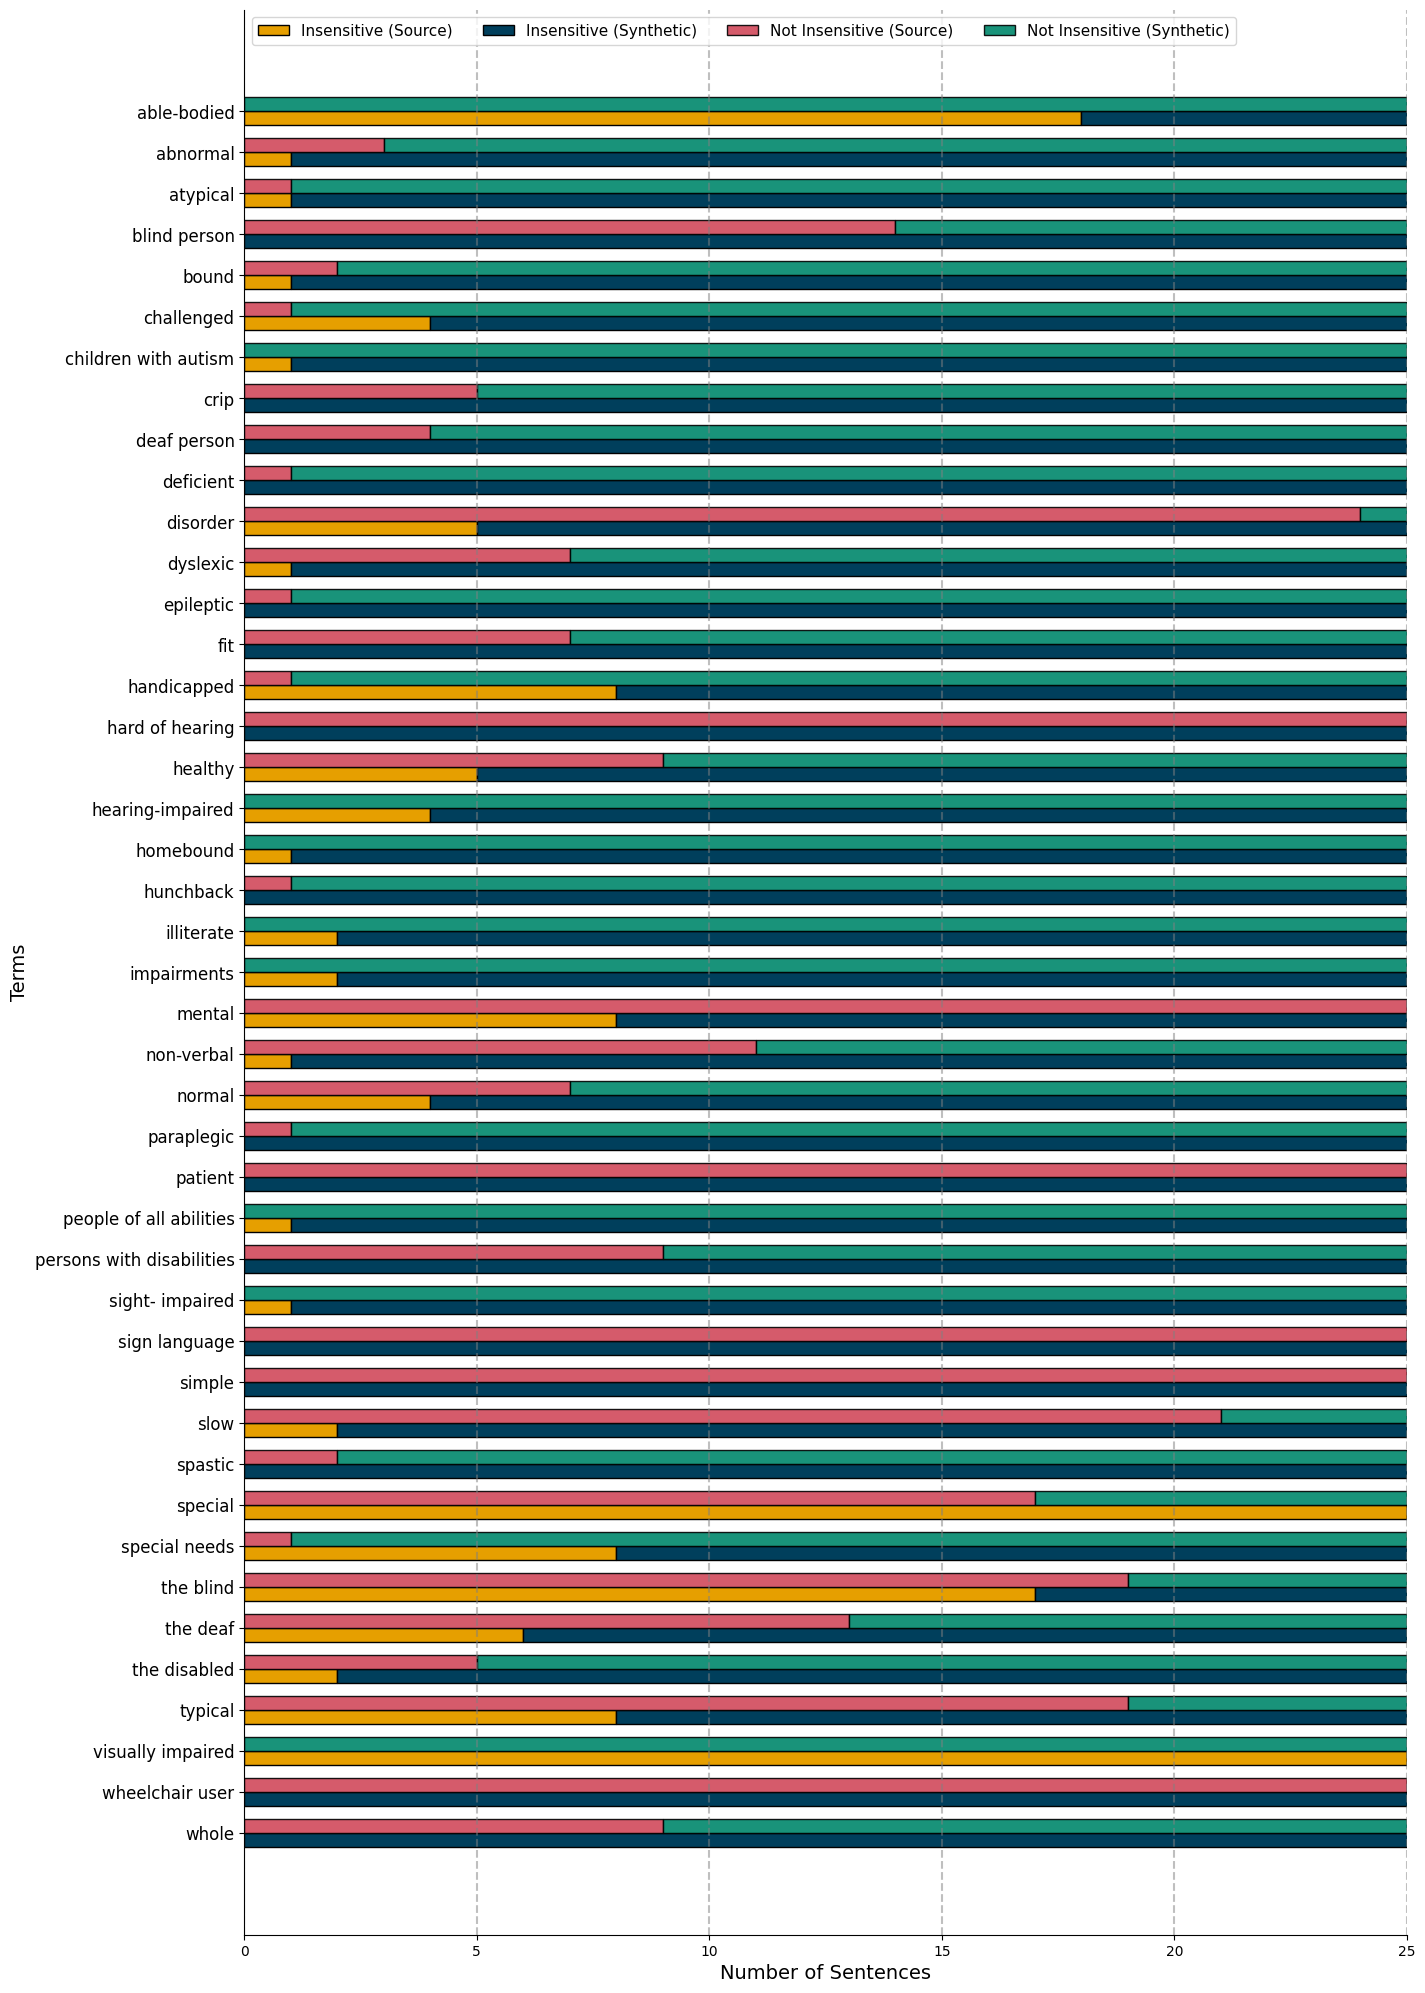

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# data
path = '/content/drive/MyDrive/Honours MiscData(Roshna)/25Augmented_annotationsV2.csv'
data = pd.read_csv(path)
term_summary = (
    data.groupby(['Term', 'Source', 'Label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# reverse alphabetical order
terms = sorted(term_summary['Term'].unique(), reverse=True)

insensitive_original = []
insensitive_gpt = []
not_insensitive_original = []
not_insensitive_gpt = []

for term in terms:
    term_data = term_summary[term_summary['Term'] == term]

    # Filling missing values 0
    original = term_data[term_data['Source'] == 'Original']
    gpt = term_data[term_data['Source'] == 'ChatGPT']

    insensitive_original.append(original[1].values[0] if not original.empty else 0)
    not_insensitive_original.append(original[0].values[0] if not original.empty else 0)
    insensitive_gpt.append(gpt[1].values[0] if not gpt.empty else 0)
    not_insensitive_gpt.append(gpt[0].values[0] if not gpt.empty else 0)


y = [i * 3.5 for i in range(len(terms))]  #spacing between terms
height = 1.2

plt.figure(figsize=(15, 25))
plt.barh(
    [p - height / 2 for p in y],
    insensitive_original,
    height=height,
    label="Insensitive (Source)",
    color='#e69f00',
    edgecolor='black'
)
plt.barh(
    [p - height / 2 for p in y],
    insensitive_gpt,
    height=height,
    left=insensitive_original,
    label="Insensitive (Synthetic)",
    color='#003f5c',
    edgecolor='black'
)

plt.barh(
    [p + height / 2 for p in y],
    not_insensitive_original,
    height=height,
    label="Not Insensitive (Source)",
    color='#d1495b',
    edgecolor='black',
    alpha=0.9
)
plt.barh(
    [p + height / 2 for p in y],
    not_insensitive_gpt,
    height=height,
    left=not_insensitive_original,
    label="Not Insensitive (Synthetic)",
    color='#00876c',
    edgecolor='black',
    alpha=0.9
)

plt.xlim(0, max(insensitive_original + insensitive_gpt + not_insensitive_original + not_insensitive_gpt))
plt.xlabel("Number of Sentences", fontsize=14)
plt.ylabel("Terms", fontsize=14)
plt.yticks(ticks=y, labels=terms, fontsize=12)  # terms on the y-axis

max_x = plt.xlim()[1]
for x in range(0, 25 + 1, 5):
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)

plt.legend(
    fontsize= 11,
    ncol=4,
    loc='upper left'
)
# Remove top and right border (spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('distribution_by_term_horizontaln.png', dpi=300, bbox_inches='tight')
plt.show()


Synthetic sentences: 1623 (75.49% of total)
Original sentences: 527 (24.51% of total)


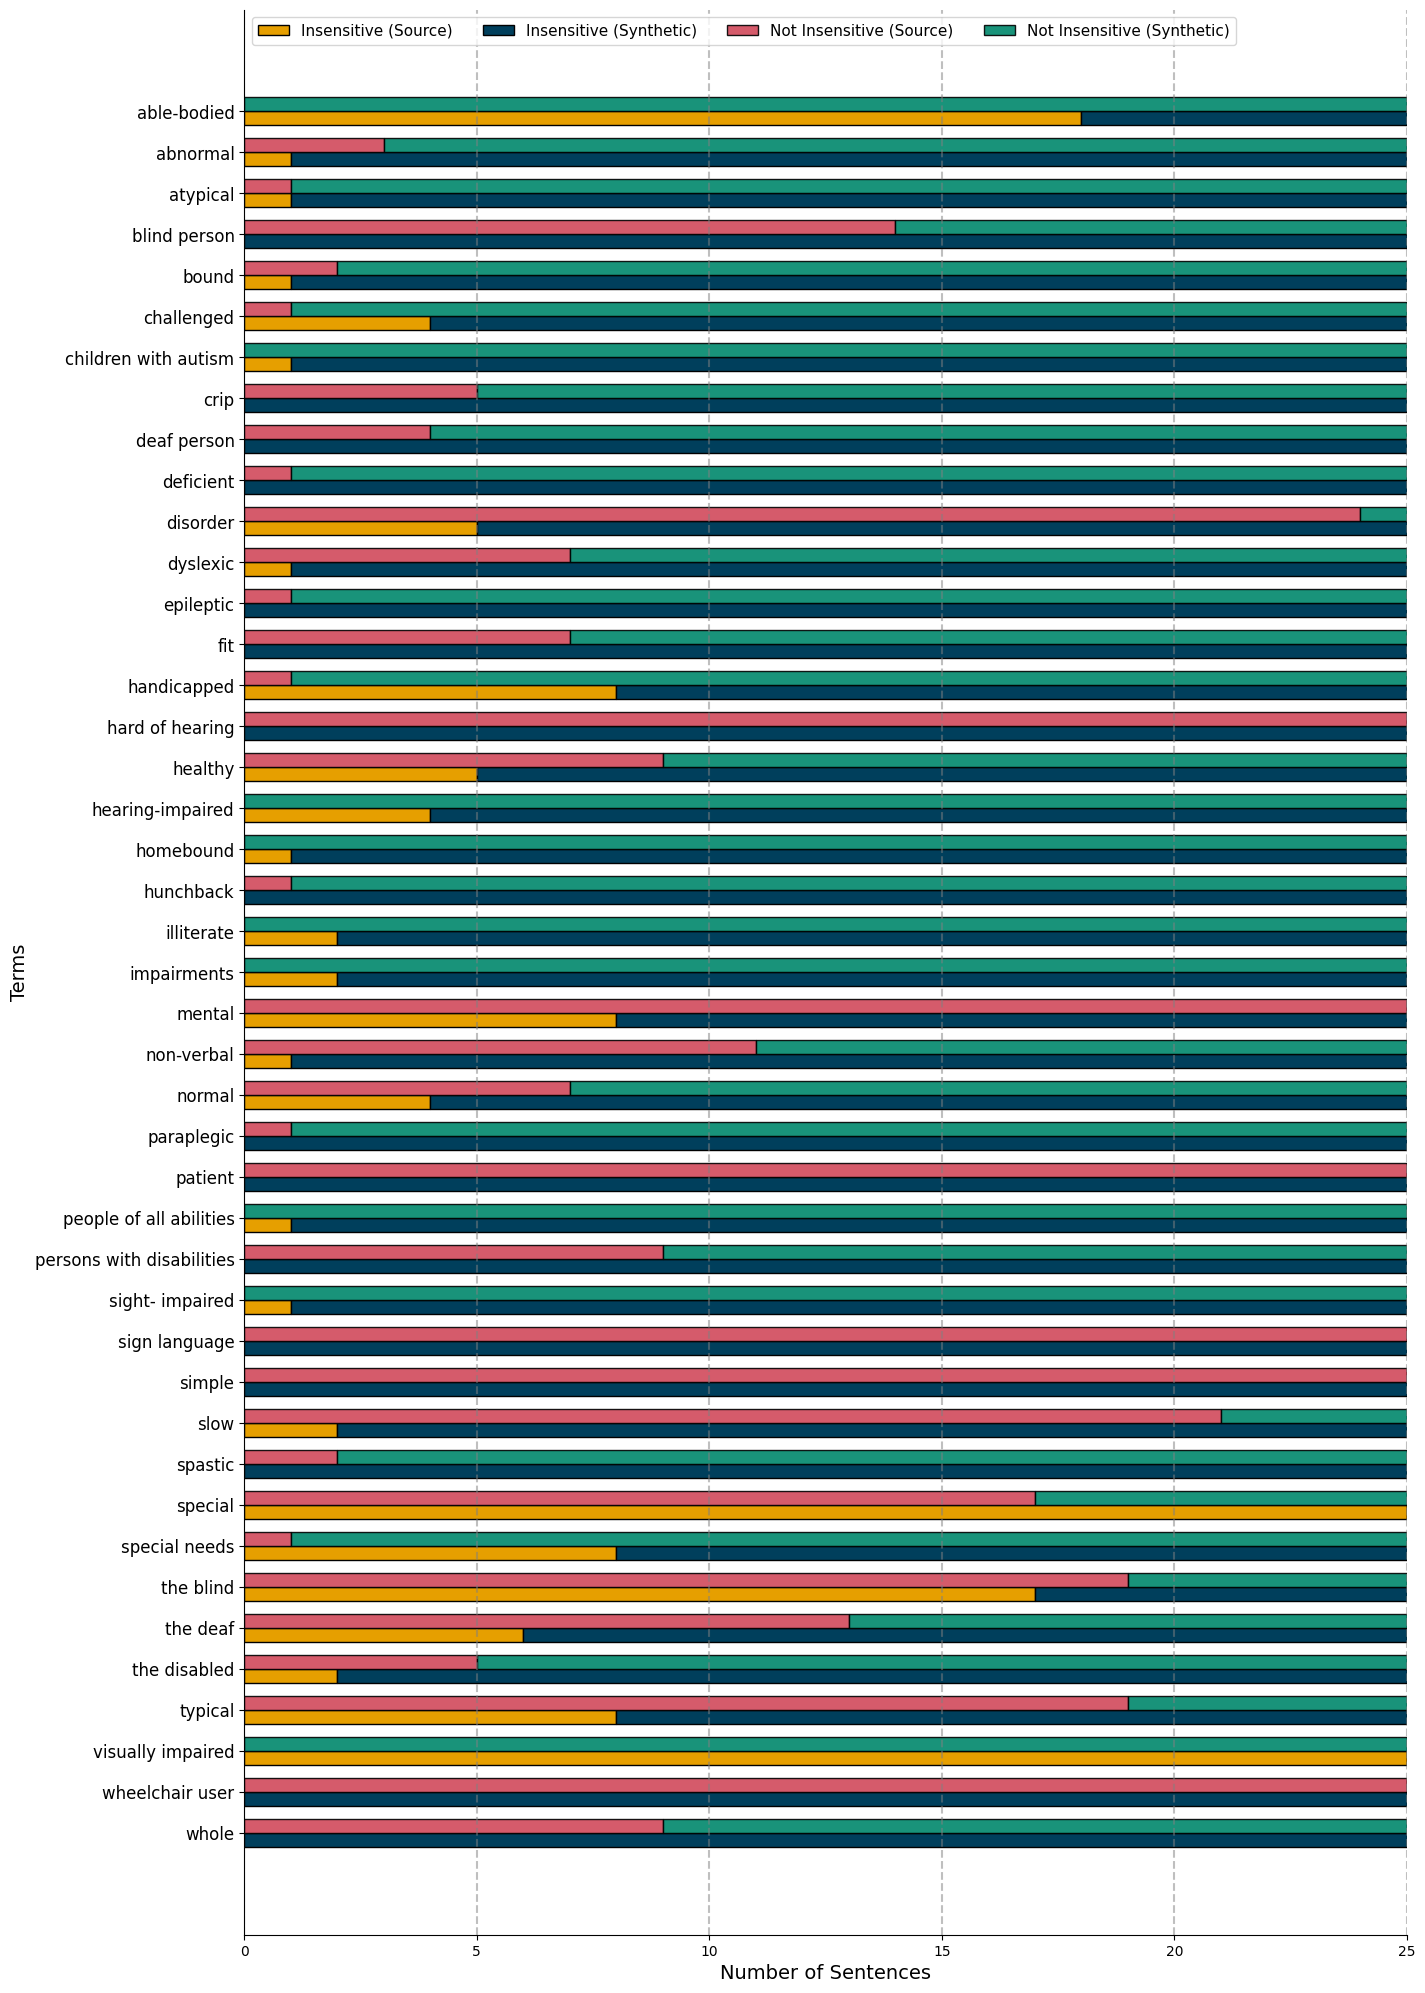

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# data
path = '/content/drive/MyDrive/Honours MiscData(Roshna)/25Augmented_annotationsV2.csv'
data = pd.read_csv(path)
term_summary = (
    data.groupby(['Term', 'Source', 'Label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# reverse alphabetical order
terms = sorted(term_summary['Term'].unique(), reverse=True)

insensitive_original = []
insensitive_gpt = []
not_insensitive_original = []
not_insensitive_gpt = []

for term in terms:
    term_data = term_summary[term_summary['Term'] == term]

    # Filling missing values with 0
    original = term_data[term_data['Source'] == 'Original']
    gpt = term_data[term_data['Source'] == 'ChatGPT']

    insensitive_original.append(original[1].values[0] if not original.empty else 0)
    not_insensitive_original.append(original[0].values[0] if not original.empty else 0)
    insensitive_gpt.append(gpt[1].values[0] if not gpt.empty else 0)
    not_insensitive_gpt.append(gpt[0].values[0] if not gpt.empty else 0)

# --- Synthetic Percentage Calculation ---
total_synthetic = sum(insensitive_gpt) + sum(not_insensitive_gpt)
total_original = sum(insensitive_original) + sum(not_insensitive_original)
total_all = total_synthetic + total_original

synthetic_percentage = (total_synthetic / total_all) * 100
print(f"Synthetic sentences: {total_synthetic} ({synthetic_percentage:.2f}% of total)")
print(f"Original sentences: {total_original} ({100 - synthetic_percentage:.2f}% of total)")
# ----------------------------------------

# Plotting
y = [i * 3.5 for i in range(len(terms))]  # spacing between terms
height = 1.2

plt.figure(figsize=(15, 25))
plt.barh(
    [p - height / 2 for p in y],
    insensitive_original,
    height=height,
    label="Insensitive (Source)",
    color='#e69f00',
    edgecolor='black'
)
plt.barh(
    [p - height / 2 for p in y],
    insensitive_gpt,
    height=height,
    left=insensitive_original,
    label="Insensitive (Synthetic)",
    color='#003f5c',
    edgecolor='black'
)

plt.barh(
    [p + height / 2 for p in y],
    not_insensitive_original,
    height=height,
    label="Not Insensitive (Source)",
    color='#d1495b',
    edgecolor='black',
    alpha=0.9
)
plt.barh(
    [p + height / 2 for p in y],
    not_insensitive_gpt,
    height=height,
    left=not_insensitive_original,
    label="Not Insensitive (Synthetic)",
    color='#00876c',
    edgecolor='black',
    alpha=0.9
)

plt.xlim(0, max(insensitive_original + insensitive_gpt + not_insensitive_original + not_insensitive_gpt))
plt.xlabel("Number of Sentences", fontsize=14)
plt.ylabel("Terms", fontsize=14)
plt.yticks(ticks=y, labels=terms, fontsize=12)

max_x = plt.xlim()[1]
for x in range(0, 25 + 1, 5):
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)

plt.legend(
    fontsize=11,
    ncol=4,
    loc='upper left'
)

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save plot
plt.savefig('distribution_by_term_horizontaln.png', dpi=300, bbox_inches='tight')
plt.show()
